In [ ]:
## 업비트

In [1]:
import requests

def get_binance_price():
    """바이낸스에서 SHIBUSDT 가격 가져오기"""
    url = "https://api.binance.com/api/v3/ticker/price"
    params = {"symbol": "SHIBUSDT"}
    response = requests.get(url, params=params)
    return float(response.json()["price"])

def get_upbit_price():
    """업비트에서 SHIB/KRW 가격 가져오기"""
    url = "https://api.upbit.com/v1/ticker"
    params = {"markets": "KRW-SHIB"}
    response = requests.get(url, params=params)
    return float(response.json()[0]["trade_price"])

def get_usd_to_krw():
    """신뢰할 수 있는 API에서 환율 가져오기 (네이버 금융)"""
    url = "https://api.exchangerate-api.com/v4/latest/USD"  # 신뢰할 수 있는 환율 API
    response = requests.get(url)
    data = response.json()
    return float(data["rates"]["KRW"])  # USD → KRW 환율 값


In [45]:
# 실시간 데이터 가져오기
binance_price = get_binance_price()  # 바이낸스 가격 (USDT)
upbit_price = get_upbit_price()  # 업비트 가격 (KRW)
usd_to_krw = get_usd_to_krw()  # 환율

# 김치 프리미엄 계산
kimchi_premium = ((upbit_price / (binance_price * usd_to_krw)) - 1) * 100

# 결과 출력
print(f"📌 SHIB 현재 가격 (업비트): {upbit_price} KRW")
print(f"📌 SHIB 현재 가격 (바이낸스): {binance_price} USDT")
print(f"📌 환율 (USD → KRW): {usd_to_krw}")
print(f"🔥 김치 프리미엄: {kimchi_premium:.2f}%")


📌 SHIB 현재 가격 (업비트): 0.01911 KRW
📌 SHIB 현재 가격 (바이낸스): 1.267e-05 USDT
📌 환율 (USD → KRW): 1458.82
🔥 김치 프리미엄: 3.39%


In [5]:
import requests
import pandas as pd
import time

# ✅ 업비트 시세 가져오기 (5분 단위 캔들)
def get_upbit_data(market="KRW-SHIB", count=200):
    url = f"https://api.upbit.com/v1/candles/minutes/5"
    params = {"market": market, "count": count}
    headers = {"Accept": "application/json"}

    response = requests.get(url, params=params, headers=headers)
    data = response.json()

    df = pd.DataFrame(data)
    df = df[["candle_date_time_kst", "opening_price", "high_price", "low_price", "trade_price", "candle_acc_trade_volume"]]
    df.columns = ["timestamp", "open", "high", "low", "close", "volume"]
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    return df

# ✅ 주요 코인 리스트
coins = ["KRW-SHIB", "KRW-BTC", "KRW-ETH", "KRW-XRP", "KRW-DOGE"]

# ✅ 모든 코인 데이터 가져오기
all_data = {}
for coin in coins:
    all_data[coin] = get_upbit_data(coin, count=1000)
    time.sleep(0.5)  # API 요청 간격 조정

# ✅ 데이터프레임 병합 (timestamp 기준)
df = all_data["KRW-SHIB"]
for coin in coins[1:]:
    df = df.merge(all_data[coin], on="timestamp", suffixes=("", f"_{coin.split('-')[1]}"))

# ✅ CSV 저장
df.to_csv("data/upbit_shib_5m.csv", index=False)
print("✅ 데이터 저장 완료!")


✅ 데이터 저장 완료!


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    200 non-null    datetime64[ns]
 1   open         200 non-null    float64       
 2   high         200 non-null    float64       
 3   low          200 non-null    float64       
 4   close        200 non-null    float64       
 5   volume       200 non-null    float64       
 6   open_BTC     200 non-null    float64       
 7   high_BTC     200 non-null    float64       
 8   low_BTC      200 non-null    float64       
 9   close_BTC    200 non-null    float64       
 10  volume_BTC   200 non-null    float64       
 11  open_ETH     200 non-null    float64       
 12  high_ETH     200 non-null    float64       
 13  low_ETH      200 non-null    float64       
 14  close_ETH    200 non-null    float64       
 15  volume_ETH   200 non-null    float64       
 16  open_XRP

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# ✅ 📌 데이터 로드 (업비트에서 가져온 CSV 파일 사용)
df = pd.read_csv("data/upbit_shib_5m.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

# ✅ 📌 새로운 특성 추가 (거래량 변화율 및 이동 평균)
df["volume_change"] = df["volume"].pct_change().fillna(0)  # 거래량 변화율
df["volume_ma5"] = df["volume"].rolling(window=5).mean().fillna(0)  # 5개 평균 거래량
df["volume_ma10"] = df["volume"].rolling(window=10).mean().fillna(0)  # 10개 평균 거래량

# ✅ 📌 학습에 사용할 특성 선택
features = ["open", "high", "low", "close", "volume", "volume_change", "volume_ma5", "volume_ma10"]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

# ✅ 📌 시퀀스 데이터 생성 함수
SEQ_LENGTH = 100  # 과거 100개의 데이터 사용 (약 8시간)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 10):  # 10개 시점까지 예측
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+10, 3])  # Close 가격 10개 예측
    return np.array(X), np.array(y)

# ✅ 📌 시퀀스 데이터 생성
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# ✅ 📌 훈련, 검증, 테스트 분할
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ✅ 📌 모델 정의
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(10)  # 10개의 미래 예측
])

# ✅ 📌 모델 컴파일 및 학습
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# ✅ 📌 체크포인트 및 얼리 스토핑
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("crypto_model.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# ✅ 📌 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=64,
    callbacks=[checkpoint_cb, early_stopping_cb]
)


Epoch 1/50


C:\Users\kj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.6035 - mae: 0.5275

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 721ms/step - loss: 0.5992 - mae: 0.5238 - val_loss: 3.0059 - val_mae: 1.7284
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.5186 - mae: 0.4913 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.5135 - mae: 0.4888 - val_loss: 2.1945 - val_mae: 1.4660
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.4018 - mae: 0.4446 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.3982 - mae: 0.4435 - val_loss: 1.4084 - val_mae: 1.1461
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2623 - mae: 0.3690 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.2624 - mae: 0.3680 - val_loss: 0.8697 - val_mae: 0.8449
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1700 - mae: 0.2811 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.1675 - mae: 0.2783 - val_loss: 0.5654 - val_mae: 0.6560
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1076 - mae: 0.2293 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.1088 - mae: 0.2310 - val_loss: 0.4199 - val_mae: 0.5526
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1206 - mae: 0.2519 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.1187 - mae: 0.2497 - val_loss: 0.3816 - val_mae: 0.5176
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0989 - mae: 0.2374 - val_loss: 0.3918 - val_mae: 0.5070
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0833 - mae: 0.2072 - val_loss: 0.4218 - val_mae: 0.5425
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0789 - mae: 0.2083 - val_loss: 0.4037 - val_mae: 0.5426
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0718 - mae: 0.2006 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0718 - mae: 0.2006 - val_loss: 0.3231 - val_mae: 0.4849
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0717 - mae: 0.1998 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.0709 - mae: 0.1987 - val_loss: 0.2616 - val_mae: 0.4399
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0626 - mae: 0.1891 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0629 - mae: 0.1893 - val_loss: 0.2576 - val_mae: 0.4409
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0621 - mae: 0.1905 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.0639 - mae: 0.1927 - val_loss: 0.2560 - val_mae: 0.4494
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0594 - mae: 0.1857 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0589 - mae: 0.1849 - val_loss: 0.2152 - val_mae: 0.4126
Epoch 16/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0511 - mae: 0.1767 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - loss: 0.0509 - mae: 0.1763 - val_loss: 0.1850 - val_mae: 0.3815
Epoch 17/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0584 - mae: 0.1813 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.0586 - mae: 0.1817 - val_loss: 0.1739 - val_mae: 0.3681
Epoch 18/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0439 - mae: 0.1619 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0442 - mae: 0.1625 - val_loss: 0.1655 - val_mae: 0.3526
Epoch 19/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0459 - mae: 0.1623 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.0460 - mae: 0.1625 - val_loss: 0.1504 - val_mae: 0.3239
Epoch 20/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0424 - mae: 0.1568 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0433 - mae: 0.1582 - val_loss: 0.1291 - val_mae: 0.2953
Epoch 21/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0407 - mae: 0.1577 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0403 - mae: 0.1570 - val_loss: 0.1184 - val_mae: 0.2792
Epoch 22/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0424 - mae: 0.1567 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0423 - mae: 0.1567 - val_loss: 0.0986 - val_mae: 0.2549
Epoch 23/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0505 - mae: 0.1696 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.0504 - mae: 0.1694 - val_loss: 0.0763 - val_mae: 0.2337
Epoch 24/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0389 - mae: 0.1501 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0386 - mae: 0.1492 - val_loss: 0.0712 - val_mae: 0.2245
Epoch 25/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0371 - mae: 0.1482 - val_loss: 0.0745 - val_mae: 0.2245
Epoch 26/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0342 - mae: 0.1421 - val_loss: 0.0800 - val_mae: 0.2315
Epoch 27/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0356 - mae: 0.1433 - val_loss: 0.0870 - val_mae: 0.2374
Epoch 28/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0312 - mae: 0.1382 - val_loss: 0.1001 - val_mae: 0.2395
Epoch 29/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0333 - mae: 0.1417 - val_loss: 0.1081 - val_mae: 0.2426
Epoch 30/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.0302 - mae: 0.1343 - val_loss: 0.0914 - val_mae: 0.2307
Epoch 31/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0336 - mae: 0.1374 - val_loss: 0.0784 - val_mae: 0.2330
Epoch 32/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0376 - mae: 0.1

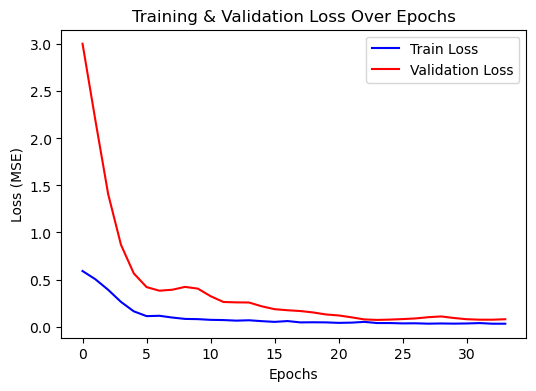

In [39]:
import matplotlib.pyplot as plt

# ✅ 📌 학습 과정 그래프
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training & Validation Loss Over Epochs')
plt.show()


In [57]:
# ✅ 📌 종가(close price) 예측이므로 해당 인덱스 설정
target_index = 3  # 'close'가 데이터셋에서 3번째 컬럼에 위치한다고 가정

# ✅ 📌 실제값 역정규화
y_test_real = scaler.inverse_transform(y_test)[:, target_index]

# ✅ 📌 예측값을 역정규화 (입력 차원 맞추기)
y_test_pred_padded = np.zeros((y_test_pred.shape[0], y_test.shape[1]))  # (N, feature_dim)로 맞춤
y_test_pred_padded[:, target_index] = y_test_pred[:, 0]  # 종가 위치에 예측값 삽입
y_test_pred_real = scaler.inverse_transform(y_test_pred_padded)[:, target_index]  # 종가만 추출

# ✅ 📌 차원 확인 (디버깅)
print(f"y_test_real.shape: {y_test_real.shape}")  # (N,)
print(f"y_test_pred_real.shape: {y_test_pred_real.shape}")  # (N,)

# ✅ 📌 예측값과 실제값 비교 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Actual SHIB Prices', color='blue')
plt.plot(y_test_pred_real, label='Predicted SHIB Prices', linestyle='dashed', color='red')

plt.xlabel('Time Steps')
plt.ylabel('SHIB Price (USDT)')
plt.legend()
plt.title('Actual vs Predicted SHIB Prices')
plt.show()



ValueError: operands could not be broadcast together with shapes (9,10) (8,) (9,10) 

In [55]:
print(f"y_test.shape: {y_test.shape}")
print(f"y_test_pred.shape: {y_test_pred.shape}")


y_test.shape: (9, 10)
y_test_pred.shape: (9, 10)


In [59]:
print(f"y_test.shape: {y_test.shape}")  # (9, 10)
print(f"y_test_pred.shape: {y_test_pred.shape}")  # (9, 10)
print(f"scaler.data_min_.shape: {scaler.data_min_.shape}")  # (feature_dim,)
print(f"scaler.data_max_.shape: {scaler.data_max_.shape}")  # (feature_dim,)


y_test.shape: (9, 10)
y_test_pred.shape: (9, 10)


AttributeError: 'StandardScaler' object has no attribute 'data_min_'

In [53]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# ✅ 📌 최신 데이터 가져오기 (마지막 100개)
last_sequence = X_test[-1:]  # 마지막 1개 배치 (1, 100, feature_dim)

# ✅ 📌 5분 단위 예측 함수
def predict_future(model, last_sequence, num_steps=288, time_interval=5, usd_to_krw=1330):
    future_preds = []
    current_sequence = last_sequence.copy()

    for _ in range(num_steps):
        next_pred = model.predict(current_sequence, verbose=0)  # (1, 10)
        future_preds.append(next_pred[0])  # 10개 예측 저장
        next_pred_reshaped = np.expand_dims(next_pred[0], axis=0)  # (1, 10)

        # 시퀀스 갱신
        current_sequence = np.concatenate((current_sequence[:, 1:, :], next_pred_reshaped.reshape(1, 1, -1)), axis=1)

    # ✅ 📌 예측값 역정규화
    max_price = scaler.mean_[3]  # Close 가격의 원래 평균값 사용
    predicted_prices = np.array(future_preds).flatten() * max_price  # 역변환 수행
    predicted_prices_krw = predicted_prices * usd_to_krw  # 원화 변환

    # ✅ 📌 미래 시간 생성
    start_time = df["timestamp"].iloc[-1]
    future_times = [start_time + timedelta(minutes=time_interval * i) for i in range(num_steps)]

    return predicted_prices, predicted_prices_krw, future_times

# ✅ 📌 5분 단위로 24시간 예측 수행
num_steps = 288  # 24시간 (5분 단위)
predicted_prices, predicted_prices_krw, future_times = predict_future(model, last_sequence, num_steps)

# ✅ 📌 예측 결과 출력
for t, price, price_krw in zip(future_times, predicted_prices, predicted_prices_krw):
    print(f"{t.strftime('%Y-%m-%d %H:%M:%S')} - Predicted SHIB Price: {price:.8f} USDT / {price_krw:.4f} KRW")

# ✅ 📌 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(future_times, predicted_prices, label="Predicted SHIB Price (USDT)", linestyle="dashed", color="red")
plt.plot(future_times, predicted_prices_krw, label="Predicted SHIB Price (KRW)", linestyle="dotted", color="blue")

plt.xlabel('Time')
plt.ylabel('SHIB Price')
plt.xticks(rotation=45)
plt.legend()
plt.title(f"SHIB Price Prediction for Next 24 Hours (5-Min Intervals)")
plt.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 8 and the array at index 1 has size 10

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ✅ 📌 LSTM 모델 정의
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=["mae"])

# ✅ 📌 체크포인트 및 얼리스탑
checkpoint = ModelCheckpoint("d250304_upbit_shib_lstm.h5", monitor="val_loss", save_best_only=True, mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# ✅ 📌 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[checkpoint, early_stopping])

# ✅ 📌 모델 저장
# model.save("shib_lstm_final.h5")
print("✅ 모델 학습 및 저장 완료!")


Epoch 1/50


C:\Users\kj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1304 - mae: 0.2979

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - loss: 0.1085 - mae: 0.2607 - val_loss: 0.0053 - val_mae: 0.0640
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0223 - mae: 0.1254 - val_loss: 0.0419 - val_mae: 0.2022
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0144 - mae: 0.0914 - val_loss: 0.1714 - val_mae: 0.4130
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0180 - mae: 0.0941 - val_loss: 0.0388 - val_mae: 0.1946
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0108 - mae: 0.0858 - val_loss: 0.0164 - val_mae: 0.1239
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0117 - mae: 0.0894 - val_loss: 0.0506 - val_mae: 0.2227
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0080 - mae: 0.0711 - val_loss: 0.0711 - val_mae: 0.2646
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0082 - mae: 0.0714 - val_loss: 0.0408 - val_mae: 0.1994
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0080 - mae: 0.0712 - val_loss: 

2025-03-04 00:45:00 - Predicted SHIB Price: 0.01876629 KRW
2025-03-04 00:50:00 - Predicted SHIB Price: 0.01897937 KRW
2025-03-04 00:55:00 - Predicted SHIB Price: 0.01923812 KRW
2025-03-04 01:00:00 - Predicted SHIB Price: 0.01950797 KRW
2025-03-04 01:05:00 - Predicted SHIB Price: 0.01976050 KRW
2025-03-04 01:10:00 - Predicted SHIB Price: 0.01998590 KRW
2025-03-04 01:15:00 - Predicted SHIB Price: 0.02018269 KRW
2025-03-04 01:20:00 - Predicted SHIB Price: 0.02033710 KRW
2025-03-04 01:25:00 - Predicted SHIB Price: 0.02042265 KRW
2025-03-04 01:30:00 - Predicted SHIB Price: 0.02049818 KRW
2025-03-04 01:35:00 - Predicted SHIB Price: 0.02056552 KRW
2025-03-04 01:40:00 - Predicted SHIB Price: 0.02061753 KRW
2025-03-04 01:45:00 - Predicted SHIB Price: 0.02066172 KRW
2025-03-04 01:50:00 - Predicted SHIB Price: 0.02070179 KRW
2025-03-04 01:55:00 - Predicted SHIB Price: 0.02073822 KRW
2025-03-04 02:00:00 - Predicted SHIB Price: 0.02077135 KRW
2025-03-04 02:05:00 - Predicted SHIB Price: 0.02080138 K

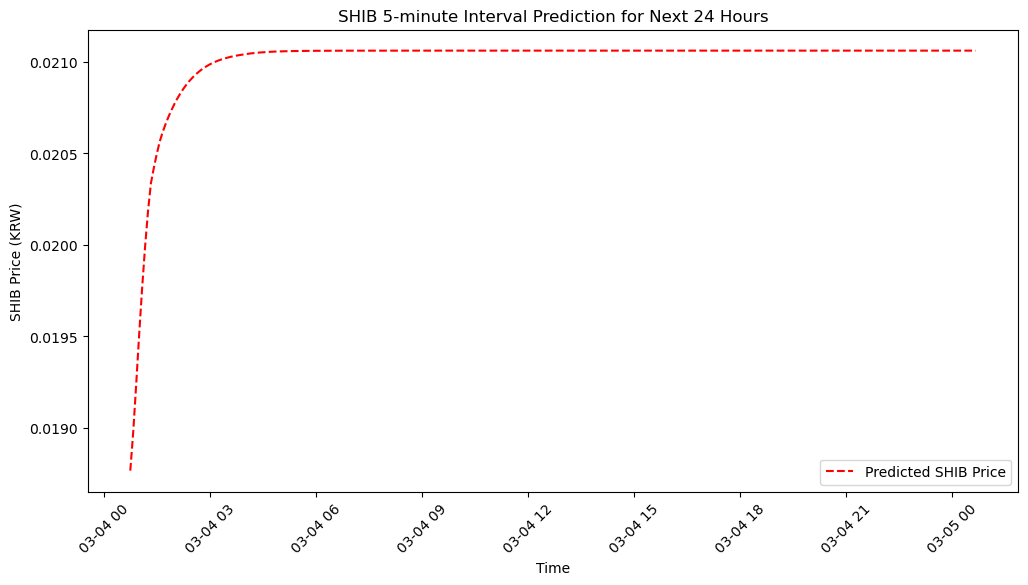

In [15]:
def predict_future(model, last_sequence, num_steps=288):
    future_preds = []
    current_sequence = last_sequence.copy()

    for _ in range(num_steps):
        next_pred = model.predict(current_sequence, verbose=0)
        future_preds.append(next_pred[0, 0])

        # 시퀀스 업데이트
        next_pred_reshaped = np.tile(next_pred, (1, 1, len(features)))
        current_sequence = np.concatenate((current_sequence[:, 1:, :], next_pred_reshaped), axis=1)

    # 역정규화
    max_price = scaler.data_max_[3]  # close price 기준
    predicted_prices = np.array(future_preds) * max_price

    return predicted_prices

# ✅ 📌 마지막 50개 데이터 가져오기
last_sequence = X_test[-1:]
predicted_prices = predict_future(model, last_sequence, num_steps=288)

# ✅ 📌 시간 생성
start_time = df["timestamp"].iloc[-1]
future_times = [start_time + pd.Timedelta(minutes=5 * i) for i in range(288)]

# ✅ 📌 결과 출력
for t, price in zip(future_times, predicted_prices):
    print(f"{t.strftime('%Y-%m-%d %H:%M:%S')} - Predicted SHIB Price: {price:.8f} KRW")



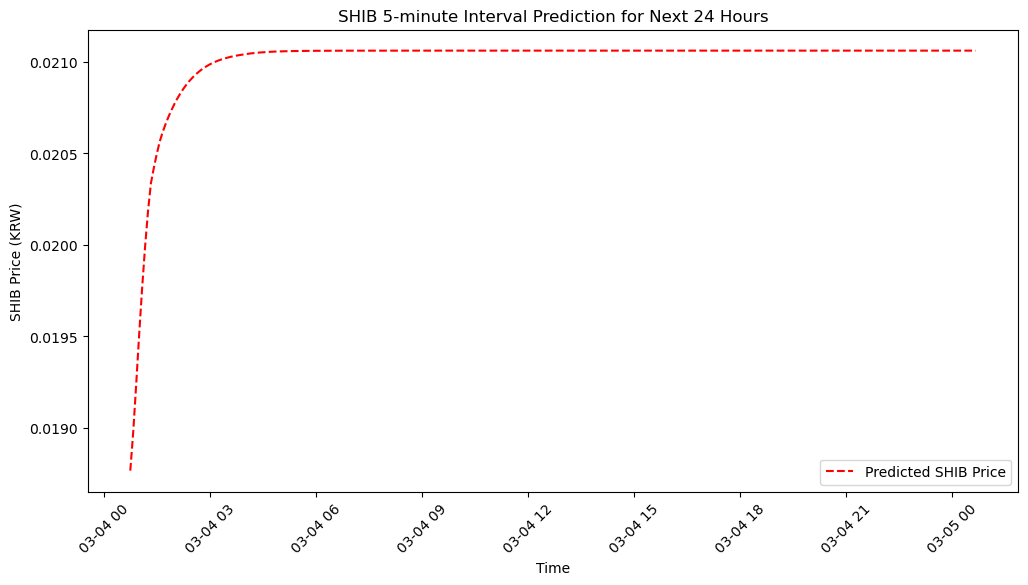

In [17]:

import matplotlib.pyplot as plt

# ✅ 📌 그래프 출력
plt.figure(figsize=(12, 6))
plt.plot(future_times, predicted_prices, label="Predicted SHIB Price", linestyle="dashed", color="red")
plt.xlabel("Time")
plt.ylabel("SHIB Price (KRW)")
plt.xticks(rotation=45)
plt.legend()
plt.title("SHIB 5-minute Interval Prediction for Next 24 Hours")
plt.show()
